In [1]:
import gym
from scipy.special import softmax as sci_softmax
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Setup environment
env = gym.make('CartPole-v1')
print('Number of states : ', env.observation_space)

Number of states :  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [3]:
# Setup environment
env = gym.make('CartPole-v1')

print('Action Space : ', env.action_space) # Discrete(2) 0: left 1: right
print('Number of Actions : ', env.action_space.n) # 2 actions left/right
print('***************')
print('Number of states : ', env.observation_space.shape[0]) # 4 positional arguments given by state

help(env.unwrapped)

Action Space :  Discrete(2)
Number of Actions :  2
***************
Number of states :  4
Help on CartPoleEnv in module gym.envs.classic_control.cartpole object:

class CartPoleEnv(gym.core.Env)
 |  Description:
 |      A pole is attached by an un-actuated joint to a cart, which moves along
 |      a frictionless track. The pendulum starts upright, and the goal is to
 |      prevent it from falling over by increasing and reducing the cart's
 |      velocity.
 |  
 |  Source:
 |      This environment corresponds to the version of the cart-pole problem
 |      described by Barto, Sutton, and Anderson
 |  
 |  Observation:
 |      Type: Box(4)
 |      Num     Observation               Min                     Max
 |      0       Cart Position             -4.8                    4.8
 |      1       Cart Velocity             -Inf                    Inf
 |      2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
 |      3       Pole Angular Velocity     -Inf           

In [4]:
# Activation Function and its Gradient
def softmax(z):

    exp = np.exp(z)

    return exp / np.sum(exp)


# Vectorized softmax Jacobian
def softmax_derivative(softmax):
    
    s = softmax.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)



In [5]:
# Function that implements Reward Discounting 
def fast_rewards(ep_rewards):
    gamma = 0.99
    gamma_rewards = np.zeros_like(ep_rewards)

    reward_ = 0

    for i in reversed(range(len(ep_rewards))):
        reward_ = reward_ * gamma + ep_rewards[i]
        gamma_rewards[i] = reward_

    # Gamma overshoots the early rewards thus we need to normalize
    #rewards_m = np.mean(gamma_rewards)
    #rewards_std = np.std(gamma_rewards)
    #gamma_rewards = (gamma_rewards - rewards_m) / rewards_std

    return gamma_rewards


# Function that implements Reward Discounting 
def fast_rewards2(ep_rewards):
    gamma = 0.99
    gamma_rewards = np.zeros_like(ep_rewards)

    reward_ = 0

    for i in reversed(range(len(ep_rewards))):
        reward_ = reward_ * gamma + ep_rewards[i]
        gamma_rewards[i] = reward_

    # Gamma overshoots the early rewards thus we need to normalize
    rewards_m = np.mean(gamma_rewards)
    rewards_std = np.std(gamma_rewards)
    gamma_rewards = (gamma_rewards - rewards_m) / rewards_std

    return gamma_rewards

In [6]:
# Activation Function of the output Layer
def softmax_act(arr):
    e_z = np.exp(arr - np.max(arr, axis=-1, keepdims=True))
    activated = e_z / np.sum(e_z, axis=-1, keepdims=True)
    return activated
#Derivative of the softmax function
def softmax_derv(activ_out):
    grad_soft = activ_out * (1 - activ_out)
    return grad_soft
# Cross entropy Loss function
def cross_entropy(predict,label):
    sample = predict.shape[0]
    prediction = np.clip(predict, 1e-15, 1 - 1e-15)
    cost = np.sum(-label * np.log(prediction) - (1 - label) * np.log(1 -prediction))
    cr_out = cost/sample
    return cr_out
# Derivative of the Loss function
def cross_derv(predict,label):
    predictions = np.clip(predict, 1e-15, 1 - 1e-15)
    der_ce = - (label/predictions) + (1 - label) / (1 - predictions)
    return der_ce

def sigmoid(z_out):
    out_act = 1/(1+np.exp(-z_out))
    
    return out_act
    
    
def sigmoid_derv(activ_out):
    
    out_der = activ_out * (1-activ_out)
    
    return out_der

def relu(z):
    
    a_re = np.where(z>=0,z,0)
    
    return a_re
    
    
def relu_grad(a_rel):
    
    
    da_re = np.where(a_rel >0,1,0)
    
    
    return da_re
    
    

In [7]:
EPISODES = 10000
lrn_rate = 0.003
# Weight Initialization
np.random.seed(12)
w_1 = np.random.rand(4, 64) / np.sqrt(4)
w_2 = np.random.rand(64, 2) / np.sqrt(64)



## Main Loop

In [9]:
# Keep track of episodic and cumulative rewards
rewards_episodic = []
rewards_cumulative = []
c_score = 0

len_ = np.zeros(EPISODES)
reward_ = np.zeros(EPISODES)
# Main loop
for e in range(EPISODES):

    obs = env.reset()[None, :]

    # Gradients list for backpropagation 

    dlog_list = []
    da_list = []
    e_rewards = []
    obs_list = []


    a2_list = []
    a1_list = []
    # reset score every episode
    e_score = 0
    
    ep_i = 0
    


    while True:

        
        if e > 8500:
            
            env.render()
            

        # Forward the observation through policy network
        z_1 = np.dot(obs, w_1)

        a_1 = relu(z_1)
        
        a1_list.append(a_1)
        
        z_2 = np.dot(a_1, w_2)
        a_2 = softmax(z_2)
        
        a2_list.append(a_2)
        action_dist = a_2
        # Sample an action from the action probability distribution
        sample_action = np.random.choice(2, p=action_dist[0])

        # Step through environment with the sample action
        obs_next, reward, done, _ = env.step(sample_action)
        obs_next = obs_next[None, :]
      
        
        obs_list.append(obs)

        # Backpropagation on Policy network
        d_test = softmax_derivative(action_dist)[sample_action, :]
        # Obtain log probability derivative
        
        d_log = d_test / action_dist[0, sample_action]
        #dw2 = a_1.T.dot(da2_log[None, :])
        
        #dz_1 = da2_log[None, :]
        #dw1 = obs.T.dot(da_1)
        
        
        # Keep track of updates and rewards 
        dlog_list.append(d_log[None,:])

        
        
        e_rewards.append(reward)

        e_score += reward
        c_score += reward

        # Set new observation as current 
        obs = obs_next
        
        ep_i += 1

        if done:
            break

    
    # UPDATE WEIGHTS AT THE END OF EVERY EPISODE
    
    # obtain discounted rewards
    #d_rewards = fast_rewards(e_rewards)

    #d_rewards -= np.mean(d_rewards)
    #d_rewards /= np.std(d_rewards)
    
    r_batch = np.vstack(e_rewards)
    
    dr_batch = fast_rewards(r_batch)
    
    # Normalize rewards 
    dr_batch = dr_batch/max(dr_batch)
    
    # Weight update
    b_size = len(obs_list)
    
    a2_batch = np.vstack(a2_list)
    
    a1_batch = np.vstack(a1_list)
    obs_batch = np.vstack(obs_list)
    #e_batch = np.vstack(err_list)
    err_batch = np.vstack(dlog_list)
    
    # Introduce discounted rewards to loss
    dA2 = err_batch 
    dA2 *= dr_batch
    #dZ2 = dA2 * softmax_derv(a2_batch)
    dZ2 = dA2
    dW2 = np.dot(a1_batch.T, dZ2)
    
    # Gradient Ascent Weight Update w2
    # w2 update 
    W2_up = lrn_rate * dW2
    w_2 += W2_up
    
    dA1 = np.dot(dZ2,w_2.T)
    dZ1 = dA1 * relu_grad(a1_batch)
    dW1 = np.dot(obs_batch.T,dZ1)
    # Gradient Ascent Weight Update w1
    # w1 update 
    W1_up = lrn_rate * dW1
    
    w_1 += W1_up
  
    # Display Performance metrics of the episode 
    len_[e] = ep_i
    reward_[e] = np.mean(len_[:e])
    
    rewards_episodic.append(e_score)
    rewards_cumulative.append(c_score)
    print("Episode: " + str(e) + " Score: " + str(e_score) + "         ", end="\r", flush=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Screen Recording LOOP

In [10]:
# Keep track of episodic and cumulative rewards
#rewards_episodic = []
#rewards_cumulative = []
#c_score = 0

#len_ = np.zeros(EPISODES)
#reward_ = np.zeros(EPISODES)
# Main loop
for e in range(20):

    obs = env.reset()[None, :]

    # Gradients list for backpropagation 

   # dlog_list = []
  #  da_list = []
 #   e_rewards = []
#    obs_list = []


    #a2_list = []
    #a1_list = []
    # reset score every episode
    e_score = 0
    
    ep_i = 0
    


    while True:
        
        env.render()
        
        

        
        #if e > 9500:
            
            #env.render()
            

        # Forward the observation through policy network
        z_1 = np.dot(obs, w_1)

        a_1 = relu(z_1)
        
        #a1_list.append(a_1)
        
        z_2 = np.dot(a_1, w_2)
        a_2 = softmax(z_2)
        
        #a2_list.append(a_2)
        action_dist = a_2
        # Sample an action from the action probability distribution
        sample_action = np.random.choice(2, p=action_dist[0])

        # Step through environment with the sample action
        obs_next, reward, done, _ = env.step(sample_action)
        obs_next = obs_next[None, :]
      
        
        #obs_list.append(obs)

        # Backpropagation on Policy network
        #d_test = softmax_derivative(action_dist)[sample_action, :]
        # Obtain log probability derivative
        
        #d_log = d_test / action_dist[0, sample_action]
        #dw2 = a_1.T.dot(da2_log[None, :])
        
        #dz_1 = da2_log[None, :]
        #dw1 = obs.T.dot(da_1)
        
        
        # Keep track of updates and rewards 
        #dlog_list.append(d_log[None,:])

        
        
        #e_rewards.append(reward)

        e_score += reward
        #c_score += reward

        # Set new observation as current 
        obs = obs_next
        
        #ep_i += 1

        if done:
            break


    

    
    #rewards_episodic.append(e_score)
    #rewards_cumulative.append(c_score)
    print("Episode: " + str(e + 9000) + " Score: " + str(e_score) + "         ", end="\r", flush=False)

## Visualization Notebook

In [15]:
r_dict = {}
r_dict['Cumulative_Average_Reward'] = reward_
r_dict['Survival_Length'] = len_


log_df = pd.DataFrame.from_dict(r_dict)
sma100 = log_df.Survival_Length.rolling(window=100).mean().to_numpy()

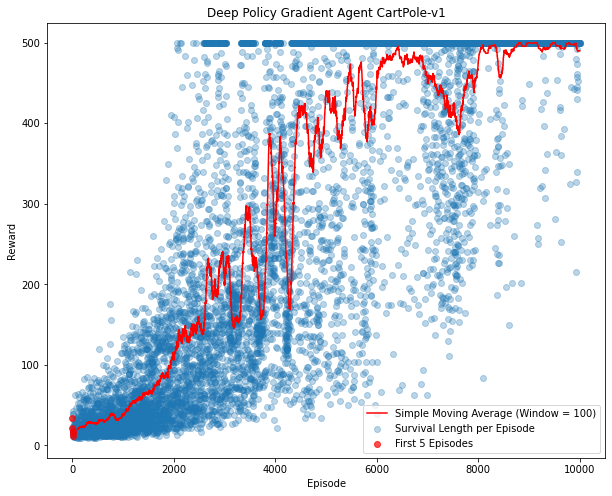

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(np.arange(5, log_df.shape[0]), log_df.Survival_Length[5:], alpha=.3)
plt.scatter(np.arange(5), log_df.Survival_Length[:5], alpha=.7, color='r')
plt.plot(np.arange(log_df.shape[0]), sma100, color='r')
plt.title('Deep Policy Gradient Agent CartPole-v1')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(['Simple Moving Average (Window = 100)', 'Survival Length per Episode', 'First 5 Episodes'], loc=4)
#plt.savefig('PolicyGradient.png')
plt.savefig('SMA_Deep_PolicyGradient.jpg',bbox_inches='tight')
plt.show(block=False)

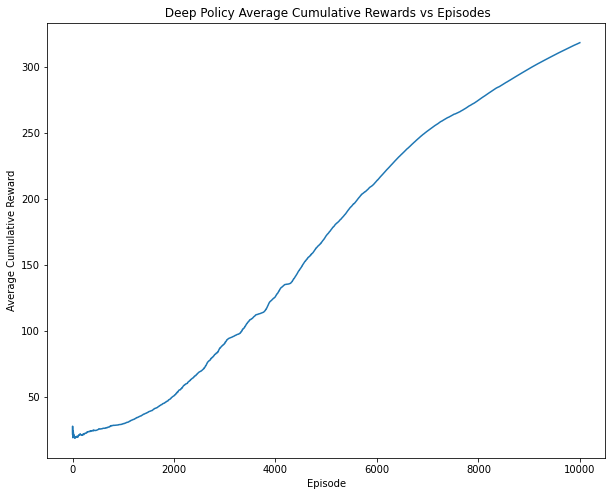

In [17]:

plt.figure(figsize=(10, 8))
plt.title(' Deep Policy Average Cumulative Rewards vs Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Cumulative Reward')
plt.plot(np.arange(EPISODES), reward_)
plt.savefig('AvrgCum_Deep_PolicyGradient.jpg',bbox_inches='tight')
#plt.savefig('2_Deep_PolicyGradient.jpg',bbox_inches='tight')
#plt.savefig('H=64|PG_cum_avrg.png')
plt.show()


## TEST PARAMS LOOP 2 

In [137]:
EPISODES = 8000
lrn_rate = 0.003
# Weight Initialization
np.random.seed(12)
w_1 = np.random.rand(4, 256) / np.sqrt(4)
w_2 = np.random.rand(256, 2) / np.sqrt(256)




In [138]:
# Keep track of episodic and cumulative rewards
rewards_episodic = []
rewards_cumulative = []
c_score = 0
# Main loop
for e in range(EPISODES):

    obs = env.reset()[None, :]

    # Gradients list for backpropagation 
    dlog_list = []
    #dz1_list = []
    #da_list = []
    e_rewards = []
    obs_list = []
    err_list = []
    labels = []
    a2_list = []
    a1_list = []
    # reset score every episode
    e_score = 0


    while True:


        # env.render()

        # Forward the observation through policy network
        z_1 = np.dot(obs, w_1)

        a_1 = relu(z_1)
        
        a1_list.append(a_1)
        
        z_2 = np.dot(a_1, w_2)
        a_2 = softmax(z_2)
        
        a2_list.append(a_2)
        action_dist = a_2
        # Sample an action from the action probability distribution
        sample_action = np.random.choice(2, p=action_dist[0])

        # Step through environment with the sample action
        obs_next, reward, done, _ = env.step(sample_action)
        obs_next = obs_next[None, :]
        
        #label = np.zeros(2)
        #label[sample_action] = 1
        #act_out = action_dist.reshape(2,)
        
        
        #labels.append(label)
        
        #error = act_out - label
        #err_list.append(error)
        
        obs_list.append(obs)

        # Backpropagation on Policy network
        d_test = softmax_derivative(action_dist)[sample_action, :]
        # Obtain log probability derivative
        
        d_log = d_test / action_dist[0, sample_action]
        #dw2 = a_1.T.dot(da2_log[None, :])
        
        #dz_1 = da2_log[None, :]
        #dw1 = obs.T.dot(da_1)
        
        
        # Keep track of updates and rewards 
        dlog_list.append(d_log[None,:])
        #dz1_list.append(dz_1)
        
        #da_list.append(a_1)
        
        e_rewards.append(reward)

        e_score += reward
        c_score += reward

        # Set new observation as current 
        obs = obs_next

        # AN EPISODE ENDED UPDATE WEIGHTS
        if done:
            break

    
    # obtain discounted rewards
    #d_rewards = fast_rewards(e_rewards)

    #d_rewards -= np.mean(d_rewards)
    #d_rewards /= np.std(d_rewards)
    
    r_batch = np.vstack(e_rewards)
    
    dr_batch = fast_rewards(r_batch)
    
    # Normalize rewards 
    dr_batch = dr_batch/max(dr_batch)
    
    # Weight update
    b_size = len(obs_list)
    
    a2_batch = np.vstack(a2_list)
    
    a1_batch = np.vstack(a1_list)
    obs_batch = np.vstack(obs_list)
    #e_batch = np.vstack(err_list)
    err_batch = np.vstack(dlog_list)
    
    
    dA2 = err_batch 
    dA2 *= dr_batch
    #dZ2 = dA2 * softmax_derv(a2_batch)
    dZ2 = dA2
    dW2 = np.dot(a1_batch.T, dZ2)
    
    # w2 update 
    W2_up = lrn_rate * dW2 
    
    w_2 += W2_up
    
    dA1 = np.dot(dZ2,w_2.T)
    dZ1 = dA1 * relu_grad(a1_batch)
    dW1 = np.dot(obs_batch.T,dZ1)
    
        # w1 update 
    W1_up = lrn_rate * dW1 
    
    w_1 += W1_up
  
    # Display Performance metrics of the episode 
    rewards_episodic.append(e_score)
    rewards_cumulative.append(c_score)
    print("Episode: " + str(e) + " Score: " + str(e_score) + "         ", end="\r", flush=False)

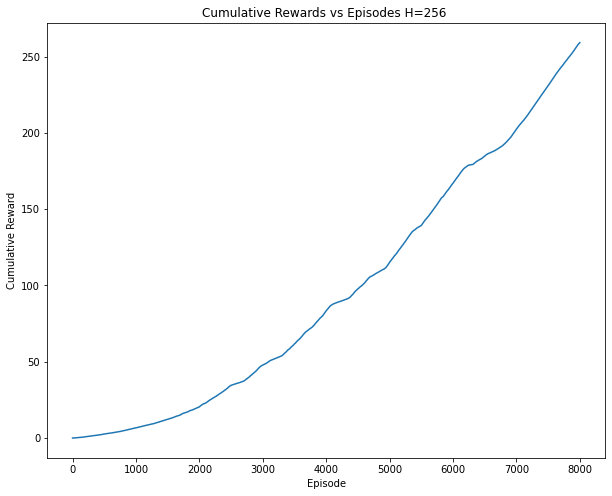

In [139]:
# Plot Cumulative Rewards
avr_cum = [r / EPISODES for r in rewards_cumulative]
plt.figure(figsize=(10, 8))
plt.title('Cumulative Rewards vs Episodes H=256 ')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.plot(np.arange(EPISODES), avr_cum)
plt.savefig('H=256|PG_cum_avrg.png')
plt.show()

## 10000 Episodes Plot 

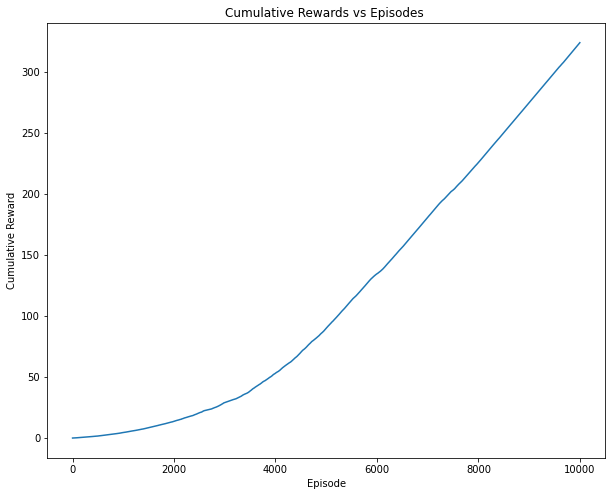

In [107]:
# Plot Cumulative Rewards
avr_cum = [r / EPISODES for r in rewards_cumulative]
plt.figure(figsize=(10, 8))
plt.title('Cumulative Rewards vs Episodes ')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.plot(np.arange(EPISODES), avr_cum)
#plt.savefig('PG_cum_avrg.png')
plt.show()